In [1]:
!nvidia-smi

Mon Aug 12 17:38:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |    986MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow import keras

#import DataGenerator as DG
from DataGenerator import DataGenerator
import JupyterProgbarLogger as Logger

import sklearn.metrics as metrics

import numpy as np
import random
import math
import os
import glob

import matplotlib.pyplot as plt

import h5py

In [3]:
###FIX NUMPY LOAD FOR DICTIONARIES
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
###Tensorflow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
depth = 10

In [5]:
model_files=["training-1098/model_progress_01.h5",
             "training-1098/model_progress_02.h5",
             "training-1098/model_progress_03.h5",
             "training-1098/model_progress_04.h5",
             "training-1098/model_progress_05.h5"]#["model-2019-07-26-20:21:18.h5",
#"model-2019-07-26-20:25:44.h5",
#"model-2019-07-26-20:36:01.h5",
#"model-2019-07-26-20:39:22.h5"]
use_single = False
single_model = "training-1595/model_progress_01.h5"#"training-968/model_progress_01.h5"
#"model-2019-07-24-19:30:14.h5",
filepath = "images_synthetic_mouse.h5"

scratch_dir = "/mnt/disks/sec/Amit/"#"/n/scratch2/ap487/"
if not os.path.exists((scratch_dir+filepath)):
    copy(filepath,scratch_dir)
    print("File Copied to scratch directory")
filepath=scratch_dir+filepath
print("Using path: ",filepath)

Using path:  /mnt/disks/sec/Amit/images_synthetic_mouse.h5


In [6]:
def accuracy(predictions, answers, top_n=5):
    accs = np.zeros(len(answers))
    predicts = np.zeros(len(test_labels))
    for i in range(0,len(answers)):
        j = len(predictions[i])-1
        for k in range(0,top_n):
            if predictions[i][j-k]==answers[i]:
                accs[i]=1
                predicts[i]=predictions[i][j-k]
    return np.mean(accs), predicts

In [7]:
with h5py.File(filepath,'r') as f:
    amt = 70000
    print("Loading Test Data: " , amt)
    data_gen = DataGenerator(filepath,data_amount=amt,batch_size=int(math.floor(amt/depth)),frames_per_sample=depth,offset=800000,sliding_window=1)
    dat,lbl = data_gen.__getitem__(0)
    test_data=dat
    test_labels=lbl
    print("Test Data loaded")  

Loading Test Data:  70000
Test Data loaded


In [8]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict_generator(DataGenerator(filepath,data_amount=800000,batch_size=32,frames_per_sample=depth,sliding_window=1)
                                                   ,verbose=0
                                                   ,callbacks=[Logger.JupyterProgbarLogger(count_mode='steps',measure_gpu=True)]) for model in members]
    yhats = np.array(yhats)
    if not use_single:
        for i in range(0,len(yhats)):
            np.save('ensemble_predics/predicts_'+str(i)+'.npy',yhats[i])
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    #result = np.argmax(summed, axis=1)
    return summed

In [9]:
models = []
if use_single:
    models.append(keras.models.load_model(single_model))
else:
    for i in range(0, len(model_files)):
        models.append(keras.models.load_model(model_files[i]))

W0812 17:38:44.012973 140572740343616 deprecation.py:323] From /home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
raw_preds=ensemble_predictions(models,test_data)
p = np.argmax(raw_preds,axis=1)
mod_p = p
s = 0
for i in range(0,len(raw_preds)):
    for j in range(1,2):
        if np.argsort(raw_preds[i])[-j]==test_labels[i]:
            #mod_p[i]=test_labels[i]
            s+=1
print(s/len(p))
conf_mat=metrics.confusion_matrix(test_labels,mod_p)
conf_mat=conf_mat / conf_mat.astype(np.float).sum(axis=1,keepdims=True)
plt.rcParams["figure.figsize"] = (14,14)
plt.imshow(conf_mat)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [ ]:
raw_preds=ensemble_predictions(models,test_data)
arr = [0]
for i in range(0,len(raw_preds)):
    a = np.argsort(raw_preds[i])
    if a[-2]==test_labels[i]:
        diff = raw_preds[i][a[-1]]-raw_preds[i][a[-2]]
        arr = np.append(arr,diff)
plt.plot(arr)
plt.show()

In [17]:
#model_benchmarks = np.load("benchmarks.npy")
#model_benchmarks.item()[name]=metrics.f1_score(test_labels,predicts,average=None)
#np.save("benchmarks.npy",model_benchmarks)
np.save("benchmarks/Ver2_2.npy",metrics.f1_score(test_labels,p,average=None))

/home/g17amitprasad_gmail_com/miniconda3/envs/tf2_gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


benchmarks/Ver1_2.npy 0.5838799963592192
benchmarks/Ver1_1.npy 0.5035154334506492
benchmarks/Ver2_1.npy 0.5850964680675242
benchmarks/Ver2_1_Ensemble.npy 0.5896001885516872
benchmarks/Ver2_2.npy 0.556889369711487


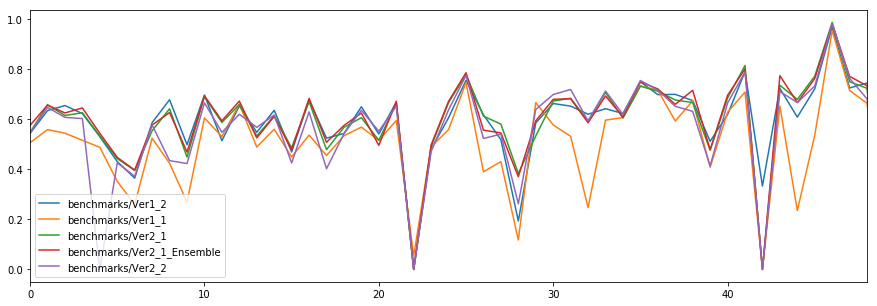

In [18]:
f1_paths = glob.glob("benchmarks/[!t23]*.npy")
plt.rcParams["figure.figsize"] = (15,5)
for path in f1_paths:
    print(path,np.mean(np.load(path)))
    plt.plot(np.load(path),label=path.split('.')[0])
plt.xlim(0,48)
plt.legend()
plt.show()

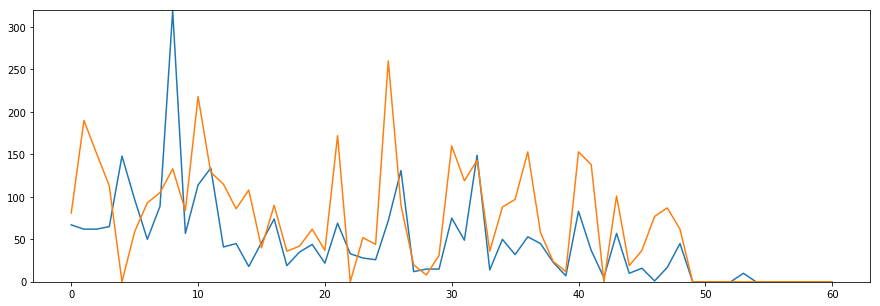

8


In [21]:
#u=np.unique(test_labels,return_counts=True)
u=np.zeros(61)#(len(np.unique(test_labels[:])))
t=np.zeros(61)
for i in range(0,len(p)):
    if not p[i]==test_labels[i]:
        x = test_labels[i]
        u[int(x)]+=1
    else:
        x = test_labels[i]
        t[int(x)]+=1
#plt.hist(u,60)
plt.plot(u)
plt.plot(t)
plt.ylim(0,320)
plt.show()
print(np.argmax(u))

In [15]:
np.save('ensemble_predics/labels.npy',test_labels)